
# Task 1 — Local Search (Hill Climbing)

**What you need to do**
- Plot a 3D surface of f(x, y); after running the algorithm, draw the path (red) of visited points on the surface.
- Implement Hill Climbing to maximize f(x, y) from O(0,0).
- Neighbor selection in O(1) time (fixed set of neighbors).
- Step size control; handle plateaus/local maxima (sideways, step halving, random restart).
- Organized OOP structure (Problem, HillClimber, Visualizer).
- Keep cell outputs when submitting.


In [1]:

# === Imports ===
import math
import random
from dataclasses import dataclass
from typing import Callable, List, Tuple, Optional, Dict

import numpy as np
import matplotlib.pyplot as plt

plt.ioff()  # for headless environments



## 1) Define f(x, y)
f(x,y) = sin(x/4) + cos(y/4) - sin((x*y)/16) + cos(x^2/16) + sin(y^2/16)


In [2]:
def f(x: float, y: float) -> float:
    return (
        math.sin(x/4.0)
        + math.cos(y/4.0)
        - math.sin((x*y)/16.0)
        + math.cos(x*x/16.0)
        + math.sin(y*y/16.0)
    )

DOMAIN_X = (-10.0, 10.0)
DOMAIN_Y = (-10.0, 10.0)



## 2) OOP — Problem: domain & O(1) neighbors
We use 8 fixed directions: (±s, 0), (0, ±s), (±s, ±s) => a constant number of candidates => select best in O(1) per step.


In [3]:

DIRS_8 = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]

@dataclass
class Problem:
    func: Callable[[float, float], float]
    x_range: Tuple[float, float]
    y_range: Tuple[float, float]

    def in_domain(self, x: float, y: float) -> bool:
        return (self.x_range[0] <= x <= self.x_range[1]) and (self.y_range[0] <= y <= self.y_range[1])

    def clamp(self, x: float, y: float) -> Tuple[float, float]:
        x = min(max(x, self.x_range[0]), self.x_range[1])
        y = min(max(y, self.y_range[0]), self.y_range[1])
        return x, y

    def neighbors(self, x: float, y: float, step: float) -> List[Tuple[float, float]]:
        cand = []
        for dx, dy in DIRS_8:
            nx, ny = x + dx*step, y + dy*step
            if self.in_domain(nx, ny):
                cand.append((nx, ny))
        return cand



## 3) OOP — HillClimber: step control & local-trap handling
- Best-neighbor in O(1): try up to 8 fixed neighbors and pick the maximum f.
- Step control: if no improvement, shrink step by 1/2 down to a minimum.
- Sideways moves (limited k) on plateaus.
- Random restarts (few) when fully stuck.


In [4]:

@dataclass
class HCResult:
    best_xy: Tuple[float, float]
    best_f: float
    path: List[Tuple[float, float]]
    history: List[Dict]

class HillClimber:
    def __init__(
        self,
        problem: Problem,
        step_init: float = 1.0,
        step_min: float = 1e-3,
        max_iter: int = 1000,
        sideways_k: int = 10,
        restarts: int = 2,
        seed: Optional[int] = 0,
    ):
        self.P = problem
        self.step_init = step_init
        self.step_min = step_min
        self.max_iter = max_iter
        self.sideways_k = sideways_k
        self.restarts = restarts
        self.rng = random.Random(seed)

    def _best_neighbor(self, x: float, y: float, step: float) -> Tuple[Tuple[float,float], float]:
        cand = self.P.neighbors(x, y, step)
        if not cand:
            return (x, y), self.P.func(x, y)
        best_xy = (x, y)
        best_val = self.P.func(x, y)
        for nx, ny in cand:
            val = self.P.func(nx, ny)
            if val > best_val:
                best_val = val
                best_xy = (nx, ny)
        return best_xy, best_val

    def _random_point(self) -> Tuple[float, float]:
        xr = self.P.x_range
        yr = self.P.y_range
        return (self.rng.uniform(xr[0], xr[1]), self.rng.uniform(yr[0], yr[1]))

    def solve(self, x0: float = 0.0, y0: float = 0.0) -> HCResult:
        best_overall_xy = (x0, y0)
        best_overall_f = self.P.func(x0, y0)
        path_global: List[Tuple[float,float]] = []
        history: List[dict] = []

        starts = [(x0, y0)] + [self._random_point() for _ in range(self.restarts)]
        for ridx, (sx, sy) in enumerate(starts):
            x, y = self.P.clamp(sx, sy)
            step = self.step_init
            sideways_left = self.sideways_k
            local_path = [(x, y)]

            for it in range(self.max_iter):
                curr_val = self.P.func(x, y)
                (nx, ny), nb_val = self._best_neighbor(x, y, step)

                improved = nb_val > curr_val
                equal = abs(nb_val - curr_val) < 1e-12

                if improved or (equal and sideways_left > 0):
                    if equal and sideways_left > 0:
                        sideways_left -= 1
                    x, y = nx, ny
                    local_path.append((x, y))
                else:
                    # no improvement -> reduce step
                    step *= 0.5
                    if step < self.step_min:
                        # local optimum
                        break

            local_best_xy = local_path[-1]
            local_best_f = self.P.func(*local_best_xy)

            path_global.extend(local_path)
            history.append({
                "restart_id": ridx,
                "start": (sx, sy),
                "end": local_best_xy,
                "f_end": local_best_f,
                "steps": len(local_path)-1
            })

            if local_best_f > best_overall_f:
                best_overall_f = local_best_f
                best_overall_xy = local_best_xy

        return HCResult(
            best_xy=best_overall_xy,
            best_f=best_overall_f,
            path=path_global,
            history=history
        )



## 4) OOP — Visualizer: 3D surface + red path
`plot_surface_with_path` draws the 3D surface and the search path (red). `plot_contour_with_path` adds a top-down contour view.


In [5]:

class Visualizer:
    def __init__(self, problem: Problem):
        self.P = problem

    def _mesh(self, n=200):
        x = np.linspace(self.P.x_range[0], self.P.x_range[1], n)
        y = np.linspace(self.P.y_range[0], self.P.y_range[1], n)
        X, Y = np.meshgrid(x, y)
        Z = np.vectorize(self.P.func)(X, Y)
        return X, Y, Z

    def plot_surface_with_path(self, path: List[Tuple[float,float]], elev=35, azim=45):
        X, Y, Z = self._mesh()
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, alpha=0.7, linewidth=0, antialiased=True)
        if path:
            xs, ys = zip(*path)
            zs = [self.P.func(x, y) for x, y in path]
            ax.plot(xs, ys, zs, color='red', linewidth=3)  # red color
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('f(x,y)')
        ax.view_init(elev=elev, azim=azim)
        ax.set_title('3D surface + path (Hill Climbing)')
        plt.show()

    def plot_contour_with_path(self, path: List[Tuple[float,float]]):
        X, Y, Z = self._mesh()
        fig = plt.figure(figsize=(7, 6))
        ax = fig.add_subplot(111)
        cs = ax.contour(X, Y, Z, levels=25)
        ax.clabel(cs, inline=True, fontsize=8)
        if path:
            xs, ys = zip(*path)
            ax.plot(xs, ys, color='red', linewidth=2)  # red color
            ax.scatter([xs[0]],[ys[0]], marker='o')  # start
            ax.scatter([xs[-1]],[ys[-1]], marker='x')  # end
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Contour + path (Hill Climbing)')
        plt.show()



## 5) Experiment from O(0,0)
Tune `step_init`, `sideways_k`, `restarts` as needed. Run all cells and keep outputs for submission.


In [6]:

# Initialize problem & solver
P = Problem(func=f, x_range=DOMAIN_X, y_range=DOMAIN_Y)
solver = HillClimber(
    problem=P,
    step_init=1.0,
    step_min=1e-3,
    max_iter=2000,
    sideways_k=10,
    restarts=2,
    seed=0
)

# Run from (0,0)
res = solver.solve(x0=0.0, y0=0.0)
print(f"Best at {res.best_xy}, f = {res.best_f:.6f}")
print(f"Path length: {len(res.path)}")
print("-- Restart summary --")
for h in res.history:
    print(h)


Best at (3.5266659916169, -4.681039994140733), f = 3.712520
Path length: 68
-- Restart summary --
{'restart_id': 0, 'start': (0.0, 0.0), 'end': (3.52734375, -4.681640625), 'f_end': 3.7125197478069474, 'steps': 23}
{'restart_id': 1, 'start': (6.888437030500963, 5.159088058806049), 'end': (9.999765155500963, 5.709869308806049), 'f_end': 3.047915162599109, 'steps': 20}
{'restart_id': 2, 'start': (-1.5885683833831, -4.821664994140733), 'end': (3.5266659916169, -4.681039994140733), 'f_end': 3.7125199957354633, 'steps': 22}



## 6) Plots (3D surface + path)


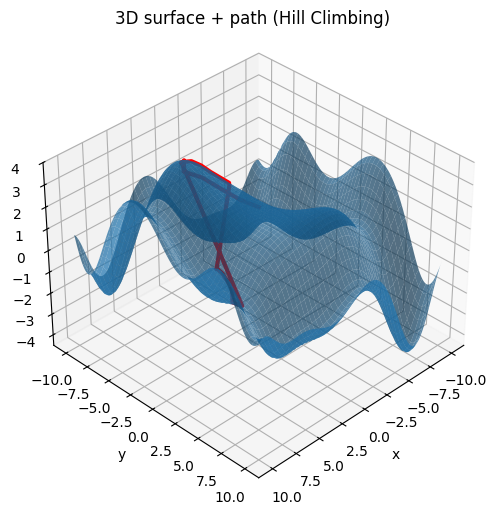

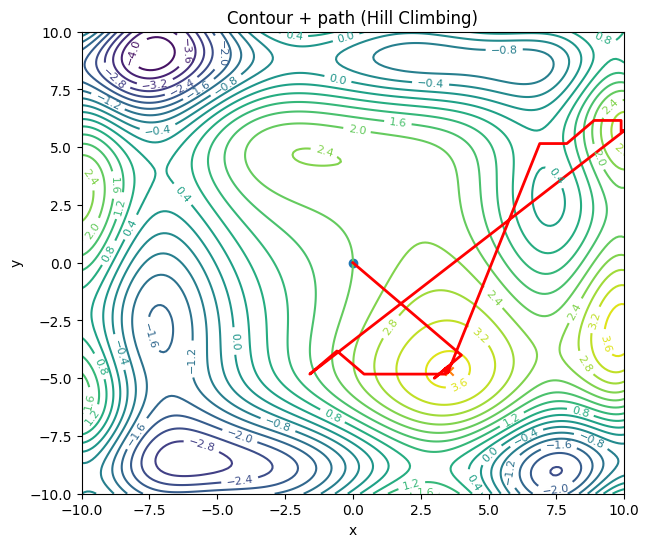

In [7]:

viz = Visualizer(P)
viz.plot_surface_with_path(res.path, elev=35, azim=45)
viz.plot_contour_with_path(res.path)



## 7) (Optional) Quick configuration comparison
Run several configurations and print a small summary table.


In [8]:

def quick_run(step_init=1.0, sideways_k=10, restarts=0, seed=0):
    s = HillClimber(P, step_init=step_init, sideways_k=sideways_k, restarts=restarts, seed=seed)
    r = s.solve(0.0, 0.0)
    return {
        "step_init": step_init,
        "sideways_k": sideways_k,
        "restarts": restarts,
        "best_xy": r.best_xy,
        "best_f": r.best_f,
        "path_len": len(r.path)
    }

configs = [
    (1.0, 0, 0),
    (1.0, 10, 0),
    (1.0, 10, 2),
    (0.5, 10, 2),
]
summary = [quick_run(si, sk, rr, seed=i) for i, (si, sk, rr) in enumerate(configs)]
for row in summary:
    print(row)


{'step_init': 1.0, 'sideways_k': 0, 'restarts': 0, 'best_xy': (3.52734375, -4.681640625), 'best_f': 3.7125197478069474, 'path_len': 14}
{'step_init': 1.0, 'sideways_k': 10, 'restarts': 0, 'best_xy': (3.52734375, -4.681640625), 'best_f': 3.7125197478069474, 'path_len': 24}
{'step_init': 1.0, 'sideways_k': 10, 'restarts': 2, 'best_xy': (3.52734375, -4.681640625), 'best_f': 3.7125197478069474, 'path_len': 62}
{'step_init': 0.5, 'sideways_k': 10, 'restarts': 2, 'best_xy': (3.52734375, -4.681640625), 'best_f': 3.7125197478069474, 'path_len': 77}



## 8) Conclusion
- Implemented Hill Climbing with O(1) neighbor selection, step control, sideways, and random restarts.
- Plotted 3D surface and the path as required.
